<a href="https://colab.research.google.com/github/tackulus/229352_KAGGLE/blob/main/229352_KAGGLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ECG.zip;

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjBYgBySkyFxcl_sOjfyYOehRVXecAHwLXD2GN96jkAYyqw4MJaTHU


In [2]:
import numpy as np
import pandas as pd


In [3]:
X_data = np.load('/content/ECG/ECG_X_train.npy')
X_data.shape

(14630, 1000, 12)

In [4]:
y_data = np.load('/content/ECG/ECG_y_train.npy')
y_data.shape

(14630,)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(X_data, y_data, test_size=.25, random_state=177)

In [6]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for k in range(X_train.shape[2]):
    scalers[k] = StandardScaler().fit(X_train[...,k])
    X_train[...,k] = scalers[k].transform(X_train[...,k])
    X_valid[...,k] = scalers[k].transform(X_valid[...,k])

In [16]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, GRU, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

inps = Input(shape=(1000, 12), name='in')
encoder = CuDNNLSTM(units=100, 
                    return_sequences=True,
                    return_state=True,
                    name='encoder')

x, state_h, state_c = encoder(inps)

decoder = CuDNNLSTM(units=100, 
                    return_sequences=True,
                    return_state=True,
                    name='decoder')

x, *_ = decoder(x, [state_h, state_c])

x = Flatten(name='flatten')(x)
outs = Dense(5, activation='softmax', name='out')(x)
model = Model(inputs=inps, outputs=outs)

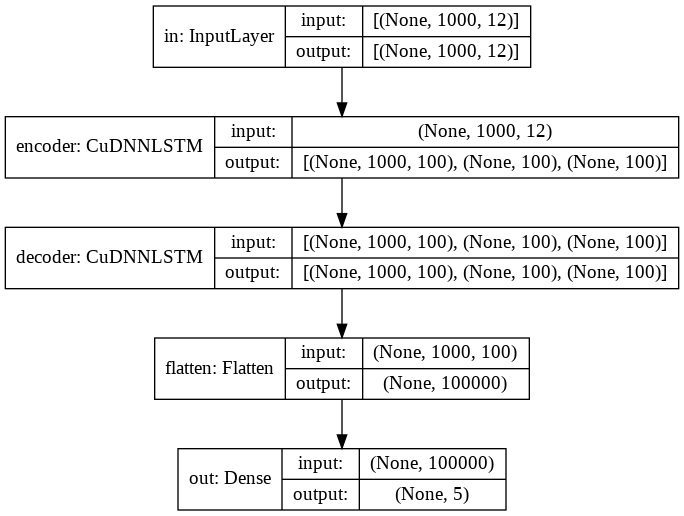

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
y_train.shape

(10972, 5)

In [52]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def make_dataset(data, target, batch_size=32):
    dataset = timeseries_dataset_from_array(
        data=data,
        targets=target,
        sequence_length=1,
        sequence_stride=1,
        shuffle=False,
        batch_size=batch_size
    )

    X, y = next(iter(dataset))
    print(">>", X.shape, y.shape)
    return dataset

train_batch = make_dataset(X_train, y_train)
valid_batch = make_dataset(X_valid, y_valid)

InternalError: ignored

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])